In [1]:
import pandas as pd
%matplotlib inline

import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PoleWard_46320 = 'drive/My Drive/Projects/PlastOPol/Datasets/PoleWard_46320.csv'
data = pd.read_csv(PoleWard_46320)
data

,L,drifter_index,time,longitude,latitude,sea_surface_temperature
0,0,46320.0,2007-06-24 18:00:00,4.285,62.821,284.916
1,1,46320.0,2007-06-25 00:00:00,4.355,62.827,284.946
2,2,46320.0,2007-06-25 06:00:00,4.410,62.846,285.001
3,3,46320.0,2007-06-25 12:00:00,4.488,62.865,284.914
4,4,46320.0,2007-06-25 18:00:00,4.526,62.870,284.894
...,...,...,...,...,...,...
196,196,46320.0,2007-08-12 18:00:00,11.346,64.988,286.983
197,197,46320.0,2007-08-13 00:00:00,11.374,64.992,286.940
198,198,46320.0,2007-08-13 06:00:00,11.384,64.990,287.063
199,199,46320.0,2007-08-13 12:00:00,11.392,64.992,287.347


In [4]:
drop_columns = ['L', 'drifter_index']
new_data = data.drop(drop_columns, axis=1)

In [5]:
hourly_data = new_data.drop(['time', 'sea_surface_temperature'], axis=1)
hourly_data

,longitude,latitude
0,4.285,62.821
1,4.355,62.827
2,4.410,62.846
3,4.488,62.865
4,4.526,62.870
...,...,...
196,11.346,64.988
197,11.374,64.992
198,11.384,64.990
199,11.392,64.992


In [6]:
dataset = hourly_data.iloc[:,:].values
# dataset = dataset.reshape(-1,1)
dataset = dataset.astype("float32")
dataset.shape
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = scaler.fit_transform(dataset)

# dataset_scaled = dataset

train_size = int(len(dataset) * 0.60)
test_size = len(dataset) - train_size
train = dataset_scaled[0:train_size,:]
test = dataset_scaled[train_size:len(dataset),:]
print("train size: {}, test size: {} ".format(len(train), len(test)))


time_stemp = 5
dataX = []
dataY = []
for i in range(len(train)-time_stemp-1):
    a = train[i:(i+time_stemp), :]
    dataX.append(a)
    dataY.append(train[i + time_stemp, :])
trainX = np.array(dataX)
trainY = np.array(dataY)  

dataX = []
dataY = []
for i in range(len(test)-time_stemp-1):
    a = test[i:(i+time_stemp), :]
    dataX.append(a)
    dataY.append(test[i + time_stemp, :])
testX = np.array(dataX)
testY = np.array(dataY) 


# time_stemp = 5
# dataX = []
# dataY = []
# for i in range(len(train)-time_stemp-1):
#     a = train[i:(i+time_stemp), :]
#     dataX.append(a)
#     dataY.append(train[i + time_stemp, :])
# trainX = np.array(dataX)
# trainY = np.array(dataY)  

# dataX = []
# dataY = []
# for i in range(len(test)-time_stemp-1):
#     a = test[i:(i+time_stemp), :]
#     dataX.append(a)
#     dataY.append(test[i + time_stemp, :])
# testX = np.array(dataX)
# testY = np.array(dataY) 


print('shape of trainX: ', trainX.shape)
print('shape of testX: ', testX.shape)
print('shape of trainY: ', trainY.shape)
print('shape of testY: ', testY.shape)

train size: 120, test size: 81 
shape of trainX:  (114, 5, 2)
shape of testX:  (75, 5, 2)
shape of trainY:  (114, 2)
shape of testY:  (75, 2)


In [7]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Initialising the RNN
regressor = Sequential()

# Adding the first RNN layer and some Dropout regularisation
regressor.add(GRU(units = 80,activation='relu', return_sequences = True , input_shape = (trainX.shape[1], 2)))
regressor.add(Dropout(0.2))

# # Adding a second RNN layer and some Dropout regularisation
# regressor.add(GRU(units = 80,activation='relu', return_sequences = True))
# regressor.add(Dropout(0.2))

# # Adding a third RNN layer and some Dropout regularisation
# regressor.add(GRU(units = 50,activation='relu', return_sequences = True))
# regressor.add(Dropout(0.2))

# # # Adding a fourth RNN layer and some Dropout regularisation
# regressor.add(GRU(units = 30,activation='relu', return_sequences = True))
# regressor.add(Dropout(0.2))

# Adding a fifth RNN layer and some Dropout regularisation
regressor.add(GRU(units = 20, return_sequences = False ))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 2))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

callback = EarlyStopping(monitor="val_loss",
                                            min_delta=0,
                                            patience=100,
                                            verbose=3,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=False,)

# Fitting the RNN to the Training set
history = regressor.fit(trainX, trainY, 
                        epochs = 500, batch_size = 64, verbose=2, 
                        validation_data = (testX, testY), callbacks=[callback], shuffle=False)

Epoch 1/500
2/2 - 4s - loss: 0.0620 - val_loss: 0.6158 - 4s/epoch - 2s/step
Epoch 2/500
2/2 - 0s - loss: 0.0448 - val_loss: 0.5310 - 47ms/epoch - 23ms/step
Epoch 3/500
2/2 - 0s - loss: 0.0392 - val_loss: 0.4499 - 37ms/epoch - 19ms/step
Epoch 4/500
2/2 - 0s - loss: 0.0267 - val_loss: 0.3732 - 37ms/epoch - 19ms/step
Epoch 5/500
2/2 - 0s - loss: 0.0207 - val_loss: 0.3026 - 38ms/epoch - 19ms/step
Epoch 6/500
2/2 - 0s - loss: 0.0123 - val_loss: 0.2406 - 39ms/epoch - 20ms/step
Epoch 7/500
2/2 - 0s - loss: 0.0124 - val_loss: 0.1887 - 37ms/epoch - 18ms/step
Epoch 8/500
2/2 - 0s - loss: 0.0110 - val_loss: 0.1477 - 42ms/epoch - 21ms/step
Epoch 9/500
2/2 - 0s - loss: 0.0115 - val_loss: 0.1192 - 39ms/epoch - 19ms/step
Epoch 10/500
2/2 - 0s - loss: 0.0122 - val_loss: 0.1019 - 36ms/epoch - 18ms/step
Epoch 11/500
2/2 - 0s - loss: 0.0136 - val_loss: 0.0932 - 39ms/epoch - 20ms/step
Epoch 12/500
2/2 - 0s - loss: 0.0127 - val_loss: 0.0902 - 46ms/epoch - 23ms/step
Epoch 13/500
2/2 - 0s - loss: 0.0133 - va

In [13]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 80)             20160     
                                                                 
 dropout (Dropout)           (None, 5, 80)             0         
                                                                 
 gru_1 (GRU)                 (None, 20)                6120      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 2)                 42        
                                                                 
Total params: 26,322
Trainable params: 26,322
Non-trainable params: 0
_________________________________________________________________


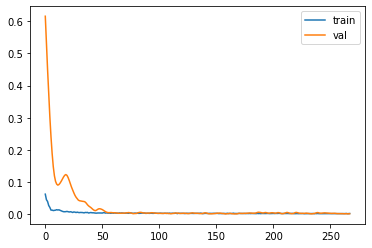

In [11]:
# summarize history for loss
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'],label="val")
plt.legend(loc="upper right")

In [14]:
import math 
from sklearn.metrics import mean_squared_error

trainPredict = regressor.predict(trainX)
testPredict = regressor.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.06 RMSE
Test Score: 0.17 RMSE


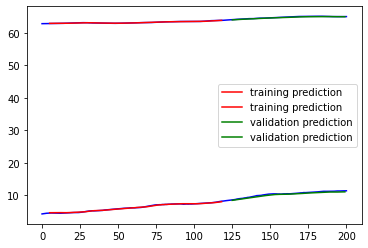

In [17]:
# shifting train
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_stemp:len(trainPredict)+time_stemp, :] = trainPredict
# shifting test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset_scaled), color='b')
plt.plot(trainPredictPlot, color='r', label = "training prediction")
plt.plot(testPredictPlot, color='g', label = "validation prediction")
plt.legend(loc="center right")
plt.show()


In [18]:
real_lon = []
real_lat = []

pred_lon = []
pred_lat = []


for i in range(trainPredict.shape[0]):
  real_lon.append(trainX[i][0])
  real_lat.append(trainX[i][1])
  
  pred_lon.append(trainPredict[i][0])
  pred_lat.append(trainPredict[i][1])



real_lat_test = []
real_lon_test = []

pred_lat_test = []
pred_lon_test = []

for i in range(testPredict.shape[0]):
  real_lon.append(testX[i][0])
  real_lat.append(testX[i][1])

  pred_lon.append(testPredict[i][0])
  pred_lat.append(testPredict[i][1])

  real_lon_test.append(testX[i][0])
  real_lat_test.append(testX[i][1])

  pred_lon_test.append(testPredict[i][0])
  pred_lat_test.append(testPredict[i][1])


print(len(real_lat))

real_test_used = scaler.inverse_transform(real_lon_test)

real_lat_test = real_test_used[:,0]
real_lon_test = real_test_used[:,1]

real_data_used = scaler.inverse_transform(real_lon)

real_lat = real_data_used[:,0]
real_lon = real_data_used[:,1]

189


In [19]:
# ignore names they dont represent test or train data

## getting the real locations of timestamps that have been used for prediction
test_data1 = data.copy()
test_data1 = test_data1[time_stemp:len(trainPredict)+time_stemp]
test_data2 = data.copy()
test_data2 = test_data2[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1]
real_data_used = pd.concat([test_data1, test_data2])
# real_data_used

## getting the predicted locations and rest of the details of timestamps that have been used for prediction
test_data1 = data.copy()
test_data1 = test_data1[time_stemp:len(trainPredict)+time_stemp]

test_data2 = data.copy()
test_data2 = test_data2[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1]

pred_data = pd.concat([test_data1, test_data2])
pred_data['drifter_index'] = 123
pred_data['longitude'] = pred_lon
pred_data['latitude'] = pred_lat
# pred_data

In [20]:
pred_data['longitude']

5       4.656744
6       4.664716
7       4.672580
8       4.679950
9       4.686753
         ...    
195    11.032559
196    11.044635
197    11.054271
198    11.066663
199    11.077186
Name: longitude, Length: 189, dtype: float32

In [21]:
plot_data = pd.concat([real_data_used, pred_data])
plot_data

,L,drifter_index,time,longitude,latitude,sea_surface_temperature
5,5,46320.0,2007-06-26 00:00:00,4.544000,62.880000,284.913
6,6,46320.0,2007-06-26 06:00:00,4.568000,62.867000,284.895
7,7,46320.0,2007-06-26 12:00:00,4.563000,62.867000,284.715
8,8,46320.0,2007-06-26 18:00:00,4.573000,62.870000,284.600
9,9,46320.0,2007-06-27 00:00:00,4.552000,62.876000,284.579
...,...,...,...,...,...,...
195,195,123.0,2007-08-12 12:00:00,11.032559,64.960670,287.216
196,196,123.0,2007-08-12 18:00:00,11.044635,64.959892,286.983
197,197,123.0,2007-08-13 00:00:00,11.054271,64.959267,286.940
198,198,123.0,2007-08-13 06:00:00,11.066663,64.959648,287.063


In [22]:
import numpy as np                   # for multi-dimensional containers 
import pandas as pd                  # for DataFrames
import plotly.graph_objects as go    # for data visualisation
import plotly.express as px

path_to_key = '/content/drive/My Drive/Projects/MapBox/mapboxkey.txt'

with open(path_to_key) as f:
    contents = f.readlines()

access_token = contents[0]
px.set_mapbox_access_token(access_token)

plot_data['size'] = 1

fig = px.scatter_mapbox(
    plot_data, lat="latitude", lon="longitude",
    size="size", size_max=5,
    color="drifter_index", color_continuous_scale=px.colors.sequential.Pinkyl,
    hover_name="longitude",           
    mapbox_style='dark', zoom=5
)

fig.layout.coloraxis.showscale = False

fig.show()

In [23]:
fig = px.scatter_mapbox(
    plot_data, lat="latitude", lon="longitude",
    size="size", size_max=5,
    color="drifter_index", color_continuous_scale=px.colors.sequential.Pinkyl,
    hover_name="time",           
    mapbox_style='dark', zoom=5,
    animation_frame="time", animation_group="longitude"
)

fig.show()

In [24]:
#speed adjustments
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 1
fig.layout.coloraxis.showscale = False
fig.layout.sliders[0].pad.t = 10
fig.layout.updatemenus[0].pad.t= 10

fig.show()

## Normalized Cumulative Lagrangian Separation (NCLS) Evaluarion

In [25]:
N = 1 # threshold

In [26]:
import numpy as np


diff_real_lat = np.diff(real_lat)
diff_real_lon = np.diff(real_lon)

In [27]:
def difference_pred_obs(reallat, reallon, predlat, predlon):
  return [sqrt(pow((reallat[i] - predlat[i]),2) + pow((reallon[i]-predlon[i]),2)) for i in range(len(reallat))]

pred_obser_diff = difference_pred_obs(real_lat, real_lon, pred_lat, pred_lon)


In [28]:
def diff_observed_data(lat, lon):
  return [sqrt(pow((lat[i] - lat[i-1]),2) + pow((lon[i]-[i-1]),2)) for i in range(1,len(lat))]


obser_diff = diff_observed_data(real_lat, real_lon)

In [29]:
lo = []
temp = 0

for i in range(len(obser_diff)):
  temp += obser_diff[i]
  lo.append(temp)


In [30]:
s = sum(pred_obser_diff)/sum(lo)

print(s) 

0.022808293812964252


In [31]:
ss = 1-s/N

print(ss)

0.9771917061870358


## Only test results

In [32]:
obser_diff_test = diff_observed_data(real_lat_test, real_lon_test)
pred_obser_diff_test = difference_pred_obs(real_lat_test, real_lon_test, pred_lat_test, pred_lon_test)

lo = []
temp = 0

for i in range(len(obser_diff_test)):
  temp += obser_diff_test[i]
  lo.append(temp)

s = sum(pred_obser_diff_test)/sum(lo)

print(s) 

ss = 1-s/N

print(ss)

0.05171799700797084
0.9482820029920291


## Trying on a second drifter


In [33]:
PoleWard_46131 = 'drive/My Drive/Projects/PlastOPol/Datasets/poleward_46131.csv'
data2 = pd.read_csv(PoleWard_46131)

drop_columns = ['L', 'drifter_index']
new_data_2 = data2.drop(drop_columns, axis=1)

hourly_data_2 = new_data_2.drop(['time', 'sea_surface_temperature'], axis=1)
hourly_data_2

dataset_2 = hourly_data_2.iloc[:,:].values
# dataset = dataset.reshape(-1,1)
dataset_2 = dataset_2.astype("float32")


dataset2_scaled = scaler.fit_transform(dataset_2)

In [34]:
dataX = []
dataY = []
for i in range(len(dataset2_scaled)-time_stemp-1):
    a = dataset2_scaled[i:(i+time_stemp), :]
    dataX.append(a)
    dataY.append(dataset2_scaled[i + time_stemp, :])
testX2 = np.array(dataX)
testY2 = np.array(dataY) 

In [35]:
testPredict2 = regressor.predict(testX2)
# invert predictions
testPredict2 = scaler.inverse_transform(testPredict2)
testY2 = scaler.inverse_transform(testY2)
# calculate root mean squared error
testScore2 = math.sqrt(mean_squared_error(testY2, testPredict2))
print('Test Score: %.2f RMSE' % (testScore2))

Test Score: 0.44 RMSE


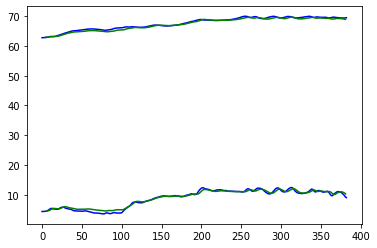

In [36]:
# shifting test predictions for plotting
testPredictPlot2 = np.empty_like(dataset_2)
testPredictPlot2[:, :] = np.nan
testPredictPlot2[(time_stemp):len(dataset_2)-1, :] = testPredict2
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset2_scaled), color='b')
# plt.plot(trainPredictPlot, color='r')
plt.plot(testPredictPlot2, color='g')
plt.show()

In [37]:
real_lat_test_2 = []
real_lon_test_2 = []

pred_lat_test_2 = []
pred_lon_test_2 = []

for i in range(testPredict2.shape[0]):

  real_lon_test_2.append(testX2[i][0])
  real_lat_test_2.append(testX2[i][1])

  pred_lon_test_2.append(testPredict2[i][0])
  pred_lat_test_2.append(testPredict2[i][1])


real_test_used_2 = scaler.inverse_transform(real_lon_test_2)

real_lat_test_2 = real_test_used_2[:,0]
real_lon_test_2 = real_test_used_2[:,1]

In [38]:
# ignore names they dont represent test or train data

## getting the real locations of timestamps that have been used for prediction
test_data1 = data2.copy()
real_data_used = test_data1[time_stemp+1:]
# real_data_used

## getting the predicted locations and rest of the details of timestamps that have been used for prediction
test_data1 = data2.copy()
test_data1 = test_data1[time_stemp+1:]

pred_data = test_data1
pred_data['drifter_index'] = 321
pred_data['longitude'] = pred_lon_test_2
pred_data['latitude'] = pred_lat_test_2
# pred_data

In [39]:
plot_data = pd.concat([real_data_used, pred_data])
plot_data

,L,drifter_index,time,longitude,latitude,sea_surface_temperature
6,6,46131.0,2007-11-23 18:00:00,4.561000,62.862000,282.304
7,7,46131.0,2007-11-24 00:00:00,4.706000,62.909000,282.242
8,8,46131.0,2007-11-24 06:00:00,4.870000,62.981000,282.576
9,9,46131.0,2007-11-24 12:00:00,5.088000,63.079000,282.450
10,10,46131.0,2007-11-24 18:00:00,5.259000,63.134000,282.450
...,...,...,...,...,...,...
378,378,321.0,2008-02-24 18:00:00,10.937068,69.105965,279.723
379,379,321.0,2008-02-25 00:00:00,10.831755,69.072250,279.666
380,380,321.0,2008-02-25 06:00:00,10.694852,69.037338,279.554
381,381,321.0,2008-02-25 12:00:00,10.525635,68.997833,279.550


In [40]:
import numpy as np                   # for multi-dimensional containers 
import pandas as pd                  # for DataFrames
import plotly.graph_objects as go    # for data visualisation
import plotly.express as px

path_to_key = '/content/drive/My Drive/Projects/MapBox/mapboxkey.txt'

with open(path_to_key) as f:
    contents = f.readlines()

access_token = contents[0]
px.set_mapbox_access_token(access_token)

plot_data['size'] = 1

fig = px.scatter_mapbox(
    plot_data, lat="latitude", lon="longitude",
    size="size", size_max=5,
    color="drifter_index", color_continuous_scale=px.colors.sequential.Pinkyl,
    hover_name="longitude",           
    mapbox_style='dark', zoom=5
)

fig.layout.coloraxis.showscale = False

fig.show()

In [41]:
obser_diff_test_2 = diff_observed_data(real_lat_test_2, real_lon_test_2)
pred_obser_diff_test_2 = difference_pred_obs(real_lat_test_2, real_lon_test_2, pred_lat_test_2, pred_lon_test_2)

lo = []
temp = 0

for i in range(len(obser_diff_test_2)):
  temp += obser_diff_test_2[i]
  lo.append(temp)

s = sum(pred_obser_diff_test_2)/sum(lo)

print(s) 

ss = 1-s/N

print(ss)

0.005532719000442532
0.9944672809995575
